## Introducción a Aprendizaje Automatico
Recopilado y Traducido por Luis Martinez para Diplomado de Inteligencia Artificial en ITLA. Referencia de:  [Tola Alade](https://blog.cambridgespark.com/how-to-determine-the-optimal-number-of-clusters-for-k-means-clustering-14f27070048f) y [Jake VanderPlas](https://colab.research.google.com/github/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/05.11-K-Means.ipynb#scrollTo=a-y2Kc9gk_bL)

## Requerimientos
- Acceso a los cuadernos

### Jupyter Notebook
- Instalar Jupyter en PC o
- Correr Colab en Google Drive

### Instalación de Jupyter en PC
- Instalar Anaconda
- Si instaló Anaconda, debe tener ya Jupyter.
- Usar pip install. 
  - "python3 -m pip install jupyter" para Python 3
  - "python -m pip install jupyter" para Python 2
Pueden acceder a: https://jupyter.org/install

### Uso de Google Colab
- Tener cuenta de Google
- Acceder a su Google Drive y crear un cuaderno

# Sin Supervisión: Clustering 1
K-means es un tipo de aprendizaje no supervisado y uno de los métodos más populares para agrupar datos no etiquetados en k grupos. Una de las tareas más complicadas en la agrupación es identificar el número apropiado de agrupaciones k.

## Leer datos con Pandas

**Pandas:** popular biblioteca de Python para exploración, manipulación y análisis de datos

In [1]:
# Manera convencional de importar a Pandas
import pandas as pd

In [2]:
# Leer CSV directamente desde una URL y salvar resultados (Use ShareCSV) # Desde http://archive.ics.uci.edu/ml/datasets/Wholesale+customers
data = pd.read_csv('http://archive.ics.uci.edu/ml/machine-learning-databases/00292/Wholesale%20customers%20data.csv')

# Muestra las primeras 5 filas
data.head()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185


Tipos de Objectos en Pandas:

- **DataFrame:** filas y columnas (como una hoja de cálculo)
- **Series:** una sola columna

In [3]:
# Muestra las últimas 5 filas
data.tail()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
435,1,3,29703,12051,16027,13135,182,2204
436,1,3,39228,1431,764,4510,93,2346
437,2,3,14531,15488,30243,437,14841,1867
438,1,3,10290,1981,2232,1038,168,2125
439,1,3,2787,1698,2510,65,477,52


In [4]:
# Valida la forma del DataFrame (filas, columnas)
data.shape

(440, 8)

¿Cuáles son los atributos?
- FRESH: gasto anual (m.u.) en productos frescos (Continuo)
- MILK: gasto anual (m.u.) en productos lácteos (Continuo)
- GROCERY: gasto anual (m.u.) en productos comestibles (Continuo)
- FROZEN: gasto anual (m.u.) en productos congelados (Continuo)
- DETERGENTS_PAPER: gasto anual (m.u.) en detergentes y productos de papel (Continuo)
- DELICATESSEN: gasto anual (m.u.) en productos delicatessen (Continuo)
- CHANNEL: canales de clientes - Horeca (hotel / restaurante / cafetería) o canal minorista (nominal)
-  REGION: regiones de clientes: Lisnon, Oporto u Otros (Nominal)

### Separación en Categoricos y Continuos

In [5]:
categorical_features = ['Channel', 'Region']
continuous_features = ['Fresh', 'Milk', 'Grocery', 'Frozen', 'Detergents_Paper', 'Delicassen']

Podemos análisis descriptivio de los atributos continuos:

In [7]:
# TODO: Imrpimir descripción de atributos con Pandas
data[continuous_features].describe()

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
count,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000
mean,12000.297727,5796.265909,7951.277273,3071.931818,2881.493182,1524.870455
std,12647.328865,7380.377175,9503.162829,4854.673333,4767.854448,2820.105937
min,3.000000,55.000000,3.000000,25.000000,3.000000,3.000000
25%,3127.750000,1533.000000,2153.000000,742.250000,256.750000,408.250000
50%,8504.000000,3627.000000,4755.500000,1526.000000,816.500000,965.500000
75%,16933.750000,7190.250000,10655.750000,3554.250000,3922.000000,1820.250000
max,112151.000000,73498.000000,92780.000000,60869.000000,40827.000000,47943.000000


¿En promedio donde consumieron más los clientes?

### Dummies
Para usar las características categóricas, necesitamos convertir las características categóricas a binarias usando pandas "get dummies". 
![Hot Encoding](https://i.imgur.com/mtimFxh.png)

In [8]:
for col in categorical_features:
    dummies = pd.get_dummies(data[col], prefix=col)
    data = pd.concat([data, dummies], axis=1)
    data.drop(col, axis=1, inplace=True)
    
# TODO: Imprimir 5 primeros elementos
data.head()

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,Channel_1,Channel_2,Region_1,Region_2,Region_3
0,12669,9656,7561,214,2674,1338,0,1,0,0,1
1,7057,9810,9568,1762,3293,1776,0,1,0,0,1
2,6353,8808,7684,2405,3516,7844,0,1,0,0,1
3,13265,1196,4221,6404,507,1788,1,0,0,0,1
4,22615,5410,7198,3915,1777,5185,0,1,0,0,1


## Procesamiento de Atributos
Para dar igual importancia a todas las características, necesitamos escalar las características continuas. Utilizaremos MinMaxScaler de scikit-learn ya que la matriz de características es una mezcla de características binarias y continuas. Otras alternativas incluyen StandardScaler.

Para cada valor en una función, MinMaxScaler resta el valor mínimo en la función y luego se divide por el rango. El rango es la diferencia entre el máximo original y el mínimo original. [Más información sobre Normalización, Standarización en Scikit learn.](https://towardsdatascience.com/scale-standardize-or-normalize-with-scikit-learn-6ccc7d176a02)

In [9]:
# TODO: Importar de que libreria proviene (scikit learn)
from sklearn.preprocessing import MinMaxScaler
mms = MinMaxScaler()
mms.fit(data)
data_transformed = mms.transform(data)

#### Validar forma de la nueva data transformada

In [10]:
# TODO: Validar forma de datos
data_transformed.shape

(440, 11)

## ¿Cuál es el valor de K?
Para cada valor de k, inicializaremos k-medias y usaremos el atributo de inercia para identificar la suma de las distancias al cuadrado de las muestras al centro del grupo más cercano.

In [11]:
# TODO: Importar modelo
from sklearn.cluster import KMeans

# Calculando valores de K con Inercia
Sum_of_squared_distances = []
K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(data_transformed)
    Sum_of_squared_distances.append(km.inertia_)

A medida que k aumenta, la suma de la distancia al cuadrado tiende a cero. Imagine que establecemos k en su valor máximo n (donde n es el número de muestras) cada muestra formará su propio grupo, lo que significa que la suma de distancias al cuadrado es igual a cero.

### Método del Codo

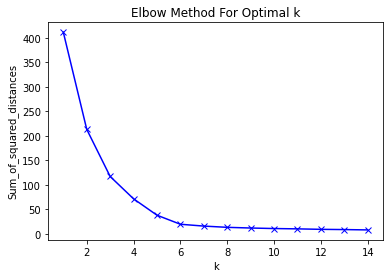

In [12]:
# TODO: Importar la libreria para gráfica (matplotlib) en su común forma
import matplotlib.pyplot as plt

plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

En la gráfica de arriba, el codo está en k=5, lo que indica que la **k óptima para este conjunto de datos es 5.**

# Sin Supervisión: Clustering 2

## K-means en digitos

Aquí intentaremos usar k-means para tratar de identificar dígitos similares sin usar la información de la etiqueta original; Esto podría ser similar a un primer paso para extraer el significado de un nuevo conjunto de datos sobre el que no tiene ninguna información de etiqueta a priori.

Comenzaremos cargando los dígitos y luego encontrando los grupos "KMeans".
Recuerde que los dígitos consisten en 1,797 muestras con 64 características, donde cada una de las 64 características es el brillo de un píxel en una imagen de 8 × 8:

In [13]:
from sklearn.datasets import load_digits
digits = load_digits()
digits.data.shape

(1797, 64)

La agrupación se puede realizar como lo hicimos antes:

In [15]:
# TODO: Importar modelo
from sklearn.cluster import KMeans

# TODO: Instanciar modelo
kmeans = KMeans(n_clusters=10, random_state=0)

# Entrenar modelo y predecir de manera instantea
clusters = kmeans.fit_predict(digits.data)

# Validar forma de centroids
kmeans.cluster_centers_.shape

(10, 64)

El resultado son 10 grupos en 64 dimensiones.
Observe que los centros del clúster son puntos de 64 dimensiones y pueden interpretarse como el dígito "típico" dentro del clúster.
Veamos cómo se ven estos centros de clúster:

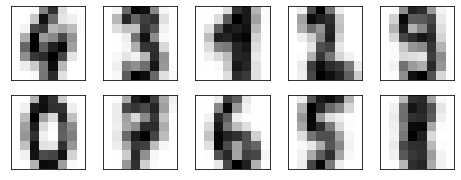

In [16]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(2, 5, figsize=(8, 3))
centers = kmeans.cluster_centers_.reshape(10, 8, 8)
for axi, center in zip(ax.flat, centers):
    axi.set(xticks=[], yticks=[])
    axi.imshow(center, interpolation='nearest', cmap=plt.cm.binary)

We see that *even without the labels*, ``KMeans`` is able to find clusters whose centers are recognizable digits, with perhaps the exception of 1 and 8.

Because *k*-means knows nothing about the identity of the cluster, the 0–9 labels may be permuted.
We can fix this by matching each learned cluster label with the true labels found in them:

Vemos que incluso sin las etiquetas, "KMeans" es capaz de encontrar grupos cuyos centros son dígitos reconocibles, con tal vez la excepción de 1 y 8.

Debido a que  k  significa que no sabe nada sobre la identidad del clúster, las etiquetas 0–9 pueden estar permutadas.
Podemos solucionar esto haciendo coincidir cada etiqueta de clúster aprendida con las etiquetas verdaderas que se encuentran en ellas:

In [17]:
# TODO: Importar NumPy en su manera común
import numpy as np
from scipy.stats import mode

labels = np.zeros_like(clusters)
for i in range(10):
    mask = (clusters == i)
    labels[mask] = mode(digits.target[mask])[0]

Ahora podemos verificar cuán precisos fueron nuestros clústeres no supervisados para encontrar dígitos similares dentro de los datos:

In [18]:
# TODO: Especificar clase para calcular precisión a traves del modulo de metrics de Scikit learn
from sklearn.metrics import accuracy_score
accuracy_score(digits.target, labels)

0.7952142459654981

¡Con un simple algoritmo de k means, descubrimos la agrupación correcta para el 80% de los dígitos de entrada!
Vamos a ver la matriz de confusión para esto:

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


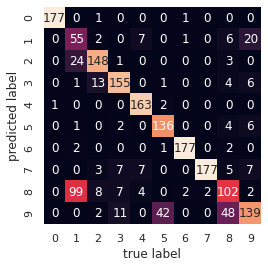

In [19]:
import seaborn as sns; sns.set()
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(digits.target, labels)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=digits.target_names,
            yticklabels=digits.target_names)
plt.xlabel('true label')
plt.ylabel('predicted label');

Como podríamos esperar de los centros de clúster que visualizamos antes, el principal punto de confusión es entre los ochos y los unos.
¡Pero esto todavía muestra que usando *k*-means, esencialmente podemos construir un clasificador de dígitos *sin referencia a ninguna etiqueta conocida*!